#AC814 - Using BERT to Predict a Company's Asset Intensity (Text Analysis)

###The goal of this notebook is to show the possibilities of predicting financial outcomes from textual data via DistilBERT transformer model. 

This notebook builds uses Business Decriptions from Google Finance

(Example: See textual **Description** of AAPL (in this case from Yahoo Finance))"

[link text](https://finance.yahoo.com/quote/AAPL/profile?p=AAPL)

This Colab notebook uses the following files that are posted on the class webite:
*   `company_des.csv` with Company descriptions of a large number of companues from Yahoo Finance

*   `ta.csv` and `rev.csv` with total assets and revenue data. This financial data was downloaded from Yahoo Finance

The steps this ipynb goes through are below: 

1.   Upload `company_des.csv` , ta.csv` and `rev.csv' from your local machine to the Colab working directory. 
2.   Install and load the necessary libraries. 
3.   Load, merge, clean the data. 
4.   Create the label variable. 
5.   Prepare the predictor.  
6.   Run the DistilBERT model. 
7.   Train logistic regression and evaluate its accuracy.





**Note**. Save this Colab notebook to your Drive via File > Save a copy in Drive to be able to edit it. 

# 1. Upload data files

Please upload the necessary files (`stock_des.csv`, `ta.csv`, `rev.csv`) in your `project_folder` folder. 

You can upload the files via `files.upload()` code cell below OR use the upload function in the window to the left (lcik on folder icon and then click on upload icon). 

In [ ]:
# Upload data
from google.colab import files
uploaded = files.upload()

Saving stock_des.csv to stock_des.csv
Saving ta.csv to ta.csv


# 2. Install, load the libraries

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 41.1 MB/s 
     |████████████████████████████████| 596 kB 30.5 MB/s 
     |████████████████████████████████| 6.5 MB 43.9 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# 2. Load, merge, clean the data

In [ ]:
# load the csv files
stock_des = pd.read_csv('stock_des.csv')
ta = pd.read_csv('ta.csv')
rev = pd.read_csv('rev.csv')

In [ ]:
# clean up the column names 
ta.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)
rev.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)

In [ ]:
# merge the dataframes into one
df = pd.merge(ta, rev, on='ticker')
df = pd.merge(df, stock_des, on='ticker')

In [ ]:
# remove the observations with ta and rev less than 10000 
print(df.shape)
df = df[(df['Total Assets'] >= 10000) & (df['Total Revenue'] >= 10000)]
print(df.shape)

(2830, 4)
(2719, 4)


count     2719.000000
mean        22.795845
std        386.905317
min          0.134677
25%          1.242993
50%          2.239040
75%          7.051726
max      18819.875000
Name: ar_ratio, dtype: float64


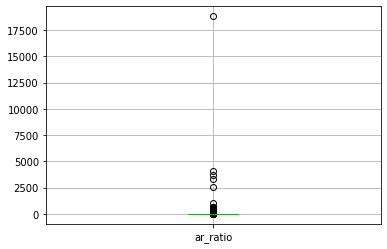

In [ ]:
# create the assets to revenue ratio 
df['ar_ratio'] = df['Total Assets']/df['Total Revenue']
print(df['ar_ratio'].describe())
df.boxplot(column='ar_ratio');

We have 6 outliers with the ratio of 1000+. Let's remove them. 

In [ ]:
df = df[df['ar_ratio']<1000]
print(df.shape)

(2713, 5)


Due to Colab's RAM limitations, limit the description size. We allow 350 characters, which is approximately 50 words and 3+ sentences. In case if you still face RAM issues try terminating other Colab notebooks (Runtime > Manage sessions) or reducing the characters to 300. 

In [ ]:
df['description'] = df['description'].str.slice(0,350)

Create a binary variable that is 1 if the assets to revenue ratio is above its median and 0 otherwise. 

This is the **dependent variable** (label) that we'll try to predict. 

In [ ]:
df['HIGH_ARR'] = (df['ar_ratio'].gt(df['ar_ratio'].median())).astype(int)

In [ ]:
df.sample(5)

,ticker,Total Assets,Total Revenue,description,ar_ratio,HIGH_ARR
753,DIS,2.015490e+11,6.538800e+10,"The Walt Disney Company, together with its sub...",3.082355,1
79,AHCO,1.813472e+09,1.056389e+09,"AdaptHealth Corp., together with its subsidiar...",1.716671,0
373,BLKB,2.044734e+09,9.132190e+08,"Blackbaud, Inc. provides cloud software soluti...",2.239040,1
101,ALBO,2.856070e+08,8.308000e+06,"Albireo Pharma, Inc., a biopharmaceutical comp...",34.377347,1
341,BGCP,3.949300e+09,1.980113e+09,"BGC Partners, Inc. operates as a brokerage and...",1.994482,0


# Preparing the predictor and DistilBERT model

**Note**. Please enable GPU in Edit > Notebook settings > Hardware accelerator. 

Load a pre-trained BERT model.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokenize the textual data for DistilBERT. 

In [ ]:
tokenized = df['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size. 

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(2713, 109)

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2713, 109)

# DistilBERT model

We run the pretrained DistilBERT model on the prepared predictor and keep the result in `last_hidden_states` variable. 

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

# Logistic regression model 



Keep the first layer of the hidden states and assign the outcome variable to `labels`. 

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = df['HIGH_ARR']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set. 

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))

0.8483063328424153


Check if this approach works better than a random guess (0.8 > 0.5). 

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.509 (+/- 0.00)
